In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
from collections import namedtuple
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

from catch import Catch

from sith import SITH
from memory_hash import HashedMemory

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
IntTensor = torch.cuda.IntTensor if use_cuda else torch.IntTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor
print(use_cuda)

False


In [21]:
"""
Reinforcement learning without going too deep.
"""

class SithSR(object):
    """SITH-based Successor Representation"""
    def __init__(self, state_len, action_len,
                 alpha=.5, neg_scaling=100., num_decays=20,
                 info_rate=1./30., dt=1./30./10., dur=1./30./10.,
                 dtype=np.float32):
        
        # save the vars
        self._dtype = dtype
        self._state_len = state_len
        self._action_len = action_len
        
        # Parameters for SITH
        self._info_rate = info_rate
        self._dt = dt
        self._dur = dur
        self._delay = info_rate - dt
        
        # Parameters for Picking Action
        self._num_decays = num_decays
        self._alpha = alpha
        self._neg_scaling = neg_scaling
        
        self.history = None
        
        # init sith
        self._in_sith = state_len
        self._sith = SITH(self._in_sith, dt=self._dt, tau_0=self._info_rate, ntau=25, dtype=self._dtype, use_cuda=use_cuda)

        # allocate for M
        self._in_M = self._sith.T.size()[0]
        self._M = torch.zeros((self._action_len, self._state_len, self._in_M)).type(FloatTensor) # (actions, outM, inM)

    def reset_T(self):
        self._sith.reset()

    def add_memory(self, state, reward):
        curr_history = torch.cat((state.view(1, -1), self._sith.T.view(-1).unsqueeze(0),
                                  FloatTensor([reward]).unsqueeze(0)),
                                  1)
        if self.history is None:
            self.history = curr_history
        else:
            self.history = torch.cat((self.history, curr_history), 0)
    def norm_M(self):
        # Normalize M Boi
        l1_normalized = torch.zeros(self._action_len,
                                    self._state_len,
                                    self._sith.tau_star[self._sith._T_full_ind].size-1,
                                    self._in_sith).type(FloatTensor)

        for i in range(self._action_len):
            l1_normalized[i] = self._M[i].view(self._state_len,
                                                self._sith.tau_star[self._sith._T_full_ind].size-1,
                                                self._in_sith)

            denom = torch.abs(l1_normalized[i]).sum(0).unsqueeze(0)
            denom[denom == 0.0] = 1.0
            normalized = l1_normalized[i]/denom.expand_as(l1_normalized[i])
            l1_normalized[i] = normalized
            
        self.l1_normalized = l1_normalized.view(model._action_len, model._state_len, (model._sith.tau_star[model._sith._T_full_ind].size-1)*model._in_sith)
       
    def pick_action(self, state):
        
        # grab the actual SITH, the first *in_sith* features are just the latest screen. 
        h = model.history[:, self._in_sith:-1].clone()
        
        # Save our rards for later
        rewards = self.history[:,-1]

        # Save t
        save_t = self._sith._t.clone()
        
        self._sith.update_t(state*self._dt, dur=self._dur)
        self._sith.update_t(item=None, dur=self._delay)
        
        # Init Potential Future Matches
        pfm_list = None
        
        # Loop over actions, calculate the prediction error for current SITH and potential future histories
        # To help select a goal state. 
        for i in range(self._num_decays):
            # Input new state+action into SITH
            pe = h - self._sith.T.view(1, -1).expand_as(h)
            
            # Sum all the positive prediction error and negative predition error
            w = 1./(1.+((pe*(pe>0).type(FloatTensor)).sum(1) + (-1 * self._neg_scaling)*(pe*(pe<0).type(FloatTensor)).sum(1)))

            if pfm_list is None:
                pfm_list = (w*rewards).clone().view(1, -1)
            else:
                pfm_list = torch.cat((pfm_list, (w*rewards).clone().view(1, -1)), 0)

            self._sith.update_t(item=None, dur=model._delay+model._dt)

        # return back to previous t
        self._sith._t = save_t
        self._sith._t_changed = True
        
        
        # PICK THE GOAL STATE BABY
        goal_state = self.history[pfm_list.cpu().numpy().sum(0).argmax(), :-1]
        goal_state = goal_state.view(self._sith.tau_star[self._sith._T_full_ind].size, self._in_sith)
        goal_state = goal_state[0].clone()
        goal_state = goal_state.view(-1)
        
        # Scaled by total PFR over drifts
        upd_pfm_list = pfm_list/pfm_list.sum(0).expand_as(pfm_list)

        # Initialize the Action to goal_state probabilities
        action_to_goal_prob = torch.zeros(self._action_len).type(FloatTensor)
        tau_pos = [0, 1, 3, 7, 15]
        
        for pos in range(self._action_len):
            ss = None
            
            for i in range(self._sith.tau_star[self._sith._T_full_ind].size-1):
                if i == 0:
                    sa_p = torch.cat((state, torch.zeros((self._sith.T.size(0) - state.size(0), 1)).type(FloatTensor)), 0)
                elif i == self._sith.tau_star[self._sith._T_full_ind].size-2:
                    sa_p = torch.cat((torch.zeros((state.size(0)*i, 1)).type(FloatTensor), state), 0)
                else:
                    sa_p = torch.cat((torch.zeros((state.size(0)*i, 1)).type(FloatTensor), state, torch.zeros((self._sith.T.size(0) - state.size(0)*(i+1), 1)).type(FloatTensor)), 0)
                
                ss = self.l1_normalized[pos].mm(sa_p).view(-1)
                action_to_goal_prob[pos] += ((ss - goal_state).dot((ss - goal_state)))*upd_pfm_list[tau_pos[i], pfm_list.cpu().numpy().sum(0).argmax()]
            
            # return back to previous t
            self._sith._t = save_t
            self._sith._t_changed = True
            
        return action_to_goal_prob.min(0)[1]

    def update_T(self, state):
        # update T with that state action
        self._sith.update_t(item=state.view(-1)*self._dt, dur=self._dur)
        self._sith.update_t(item=None, dur=self._delay)
        
    def learn_step(self, next_state, action):
        # Update the M associated with action *action* 
        self._M[action] += self._alpha * next_state.unsqueeze(1).mm(self._sith.T.unsqueeze(0))

 

In [22]:
# global params
height = 18
width=12
num_actions = 3
input_size = width * height

model = SithSR(state_len=input_size, action_len=num_actions, 
               neg_scaling=100., alpha=.001)

In [23]:
# set up the catch environment
c = Catch(screen_height=height, screen_width=width,
          game_over_conditions = {'ball_deletions': 1},
          mask=height-2, ball_spawn_rate=100000, basket_len=3)

In [24]:
training_random = 3000
training_games = 5000
test_every = 50
testing_games = 25

In [25]:
tot_score = 0.0
training_rewards = []
testing_rewards = []
# train over total epochs
for e in range(training_games):
    c.reset()
    model.reset_T()
    game_over = False
    # get initial input
    input_t = Tensor(c.observe(flatten=True))
    i = 0
    #iterate over each game
    if (np.random.rand() <= (.5 - .5*(float(e)/training_games) )) or (model.history is None) or (e < training_random):
        RUN_RANDOM = True
    else:
        RUN_RANDOM = False
    while not game_over:

        # t_-1 is the previous observation
        input_tm1 = input_t.clone()
        model.update_T(state=input_tm1)

        # Randomly pick an action, or use the
        # Previously calculated action
        if (RUN_RANDOM):
            action = (torch.rand(1) * (num_actions)).type(LongTensor)
        else:
            action = model.pick_action(input_tm1)


        # apply action, get rewards and new state
        reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)

        input_t = Tensor(c.observe(flatten=True))

        # store experience
        model.learn_step(next_state=input_t, action=action.cpu().numpy()[0])
       
        
        if reward != 0:
            save_t = model._sith._t.clone()
            model.update_T(state=input_t)
            model.add_memory(input_t, reward)
            tot_score += reward
            training_rewards += [reward]
            print(e, ": ", tot_score, reward)    
            model._sith._t = save_t.clone()
            model._sith._t_changed = True
    if (e % test_every == 0):
        model.norm_M()
        test_score = 0.0
        for i in range(testing_games):
            c.reset()
            model.reset_T()
            game_over = False
            # get initial input
            input_t = Tensor(c.observe(flatten=True))
            
            #iterate over each game
            while not game_over:

                # t_-1 is the previous observation
                input_tm1 = input_t.clone()
                model.update_T(state=input_tm1)

                # Randomly pick an action, or use the
                # Previously calculated action
                action = model.pick_action(input_tm1)


                # apply action, get rewards and new state
                reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)

                input_t = Tensor(c.observe(flatten=True))

                # store experience
                #model.learn_step(next_state=input_t, action=action.cpu().numpy()[0])


                if reward != 0:
                    test_score += reward
        print("TEST ", e, ": ", test_score/testing_games)   
        testing_rewards += [test_score/testing_games]
            

0 :  -1.0 -1
TEST  0 :  -0.44
1 :  0.0 1
2 :  -1.0 -1
3 :  -2.0 -1
4 :  -3.0 -1
5 :  -2.0 1
6 :  -3.0 -1
7 :  -4.0 -1
8 :  -5.0 -1
9 :  -6.0 -1
10 :  -7.0 -1
11 :  -8.0 -1
12 :  -7.0 1
13 :  -8.0 -1
14 :  -9.0 -1
15 :  -10.0 -1
16 :  -11.0 -1
17 :  -10.0 1
18 :  -9.0 1
19 :  -10.0 -1
20 :  -11.0 -1
21 :  -12.0 -1
22 :  -11.0 1
23 :  -12.0 -1
24 :  -13.0 -1
25 :  -14.0 -1
26 :  -15.0 -1
27 :  -14.0 1
28 :  -13.0 1
29 :  -14.0 -1
30 :  -15.0 -1
31 :  -16.0 -1
32 :  -17.0 -1
33 :  -18.0 -1
34 :  -17.0 1
35 :  -18.0 -1
36 :  -19.0 -1
37 :  -20.0 -1
38 :  -21.0 -1
39 :  -20.0 1
40 :  -21.0 -1
41 :  -20.0 1
42 :  -21.0 -1
43 :  -22.0 -1
44 :  -23.0 -1
45 :  -22.0 1
46 :  -21.0 1
47 :  -22.0 -1
48 :  -23.0 -1
49 :  -24.0 -1
50 :  -25.0 -1
TEST  50 :  -0.36
51 :  -26.0 -1
52 :  -25.0 1
53 :  -26.0 -1
54 :  -25.0 1
55 :  -26.0 -1
56 :  -25.0 1
57 :  -26.0 -1
58 :  -27.0 -1
59 :  -28.0 -1
60 :  -29.0 -1
61 :  -30.0 -1
62 :  -31.0 -1
63 :  -32.0 -1
64 :  -33.0 -1
65 :  -34.0 -1
66 :  -35.0 -1
67 

497 :  -280.0 -1
498 :  -281.0 -1
499 :  -282.0 -1
500 :  -283.0 -1
TEST  500 :  0.04
501 :  -284.0 -1
502 :  -285.0 -1
503 :  -286.0 -1
504 :  -287.0 -1
505 :  -288.0 -1
506 :  -289.0 -1
507 :  -290.0 -1
508 :  -291.0 -1
509 :  -292.0 -1
510 :  -293.0 -1
511 :  -292.0 1
512 :  -293.0 -1
513 :  -294.0 -1
514 :  -295.0 -1
515 :  -294.0 1
516 :  -293.0 1
517 :  -294.0 -1
518 :  -293.0 1
519 :  -292.0 1
520 :  -293.0 -1
521 :  -294.0 -1
522 :  -295.0 -1
523 :  -296.0 -1
524 :  -297.0 -1
525 :  -298.0 -1
526 :  -299.0 -1
527 :  -298.0 1
528 :  -299.0 -1
529 :  -300.0 -1
530 :  -301.0 -1
531 :  -302.0 -1
532 :  -303.0 -1
533 :  -304.0 -1
534 :  -303.0 1
535 :  -304.0 -1
536 :  -305.0 -1
537 :  -306.0 -1
538 :  -307.0 -1
539 :  -308.0 -1
540 :  -309.0 -1
541 :  -310.0 -1
542 :  -309.0 1
543 :  -308.0 1
544 :  -309.0 -1
545 :  -310.0 -1
546 :  -311.0 -1
547 :  -310.0 1
548 :  -311.0 -1
549 :  -310.0 1
550 :  -311.0 -1
TEST  550 :  0.12
551 :  -310.0 1
552 :  -311.0 -1
553 :  -312.0 -1
554 :  

989 :  -538.0 1
990 :  -539.0 -1
991 :  -540.0 -1
992 :  -539.0 1
993 :  -540.0 -1
994 :  -539.0 1
995 :  -540.0 -1
996 :  -541.0 -1
997 :  -542.0 -1
998 :  -543.0 -1
999 :  -544.0 -1
1000 :  -545.0 -1
TEST  1000 :  0.2
1001 :  -546.0 -1
1002 :  -547.0 -1
1003 :  -548.0 -1
1004 :  -549.0 -1
1005 :  -550.0 -1
1006 :  -551.0 -1
1007 :  -550.0 1
1008 :  -551.0 -1
1009 :  -552.0 -1
1010 :  -553.0 -1
1011 :  -554.0 -1
1012 :  -555.0 -1
1013 :  -554.0 1
1014 :  -553.0 1
1015 :  -552.0 1
1016 :  -553.0 -1
1017 :  -554.0 -1
1018 :  -555.0 -1
1019 :  -556.0 -1
1020 :  -557.0 -1
1021 :  -558.0 -1
1022 :  -559.0 -1
1023 :  -560.0 -1
1024 :  -561.0 -1
1025 :  -560.0 1
1026 :  -559.0 1
1027 :  -558.0 1
1028 :  -559.0 -1
1029 :  -560.0 -1
1030 :  -561.0 -1
1031 :  -562.0 -1
1032 :  -563.0 -1
1033 :  -564.0 -1
1034 :  -565.0 -1
1035 :  -566.0 -1
1036 :  -567.0 -1
1037 :  -568.0 -1
1038 :  -569.0 -1
1039 :  -570.0 -1
1040 :  -571.0 -1
1041 :  -570.0 1
1042 :  -569.0 1
1043 :  -570.0 -1
1044 :  -571.0 

TEST  1450 :  0.36
1451 :  -778.0 -1
1452 :  -779.0 -1
1453 :  -780.0 -1
1454 :  -781.0 -1
1455 :  -782.0 -1
1456 :  -781.0 1
1457 :  -782.0 -1
1458 :  -781.0 1
1459 :  -782.0 -1
1460 :  -783.0 -1
1461 :  -782.0 1
1462 :  -781.0 1
1463 :  -782.0 -1
1464 :  -783.0 -1
1465 :  -784.0 -1
1466 :  -785.0 -1
1467 :  -786.0 -1
1468 :  -785.0 1
1469 :  -786.0 -1
1470 :  -787.0 -1
1471 :  -788.0 -1
1472 :  -789.0 -1
1473 :  -790.0 -1
1474 :  -791.0 -1
1475 :  -790.0 1
1476 :  -791.0 -1
1477 :  -790.0 1
1478 :  -791.0 -1
1479 :  -790.0 1
1480 :  -791.0 -1
1481 :  -792.0 -1
1482 :  -793.0 -1
1483 :  -794.0 -1
1484 :  -795.0 -1
1485 :  -796.0 -1
1486 :  -795.0 1
1487 :  -796.0 -1
1488 :  -797.0 -1
1489 :  -798.0 -1
1490 :  -797.0 1
1491 :  -798.0 -1
1492 :  -799.0 -1
1493 :  -800.0 -1
1494 :  -799.0 1
1495 :  -798.0 1
1496 :  -799.0 -1
1497 :  -800.0 -1
1498 :  -801.0 -1
1499 :  -802.0 -1
1500 :  -803.0 -1
TEST  1500 :  0.2
1501 :  -802.0 1
1502 :  -801.0 1
1503 :  -802.0 -1
1504 :  -803.0 -1
1505 

1916 :  -1021.0 -1
1917 :  -1022.0 -1
1918 :  -1023.0 -1
1919 :  -1022.0 1
1920 :  -1023.0 -1
1921 :  -1024.0 -1
1922 :  -1025.0 -1
1923 :  -1026.0 -1
1924 :  -1027.0 -1
1925 :  -1028.0 -1
1926 :  -1027.0 1
1927 :  -1028.0 -1
1928 :  -1027.0 1
1929 :  -1028.0 -1
1930 :  -1029.0 -1
1931 :  -1030.0 -1
1932 :  -1031.0 -1
1933 :  -1032.0 -1
1934 :  -1033.0 -1
1935 :  -1034.0 -1
1936 :  -1033.0 1
1937 :  -1034.0 -1
1938 :  -1033.0 1
1939 :  -1034.0 -1
1940 :  -1033.0 1
1941 :  -1032.0 1
1942 :  -1033.0 -1
1943 :  -1032.0 1
1944 :  -1033.0 -1
1945 :  -1034.0 -1
1946 :  -1035.0 -1
1947 :  -1036.0 -1
1948 :  -1037.0 -1
1949 :  -1038.0 -1
1950 :  -1037.0 1
TEST  1950 :  -0.12
1951 :  -1038.0 -1
1952 :  -1037.0 1
1953 :  -1036.0 1
1954 :  -1037.0 -1
1955 :  -1038.0 -1
1956 :  -1039.0 -1
1957 :  -1040.0 -1
1958 :  -1041.0 -1
1959 :  -1042.0 -1
1960 :  -1043.0 -1
1961 :  -1042.0 1
1962 :  -1043.0 -1
1963 :  -1044.0 -1
1964 :  -1045.0 -1
1965 :  -1044.0 1
1966 :  -1045.0 -1
1967 :  -1046.0 -1
1968 

TEST  2350 :  -0.28
2351 :  -1248.0 1
2352 :  -1249.0 -1
2353 :  -1248.0 1
2354 :  -1249.0 -1
2355 :  -1248.0 1
2356 :  -1247.0 1
2357 :  -1246.0 1
2358 :  -1247.0 -1
2359 :  -1246.0 1
2360 :  -1247.0 -1
2361 :  -1248.0 -1
2362 :  -1249.0 -1
2363 :  -1250.0 -1
2364 :  -1251.0 -1
2365 :  -1252.0 -1
2366 :  -1253.0 -1
2367 :  -1254.0 -1
2368 :  -1253.0 1
2369 :  -1254.0 -1
2370 :  -1253.0 1
2371 :  -1254.0 -1
2372 :  -1255.0 -1
2373 :  -1256.0 -1
2374 :  -1255.0 1
2375 :  -1254.0 1
2376 :  -1255.0 -1
2377 :  -1256.0 -1
2378 :  -1255.0 1
2379 :  -1256.0 -1
2380 :  -1257.0 -1
2381 :  -1258.0 -1
2382 :  -1259.0 -1
2383 :  -1260.0 -1
2384 :  -1261.0 -1
2385 :  -1262.0 -1
2386 :  -1263.0 -1
2387 :  -1264.0 -1
2388 :  -1265.0 -1
2389 :  -1266.0 -1
2390 :  -1267.0 -1
2391 :  -1268.0 -1
2392 :  -1269.0 -1
2393 :  -1268.0 1
2394 :  -1269.0 -1
2395 :  -1268.0 1
2396 :  -1269.0 -1
2397 :  -1268.0 1
2398 :  -1269.0 -1
2399 :  -1270.0 -1
2400 :  -1271.0 -1
TEST  2400 :  0.04
2401 :  -1270.0 1
2402 : 

2790 :  -1455.0 -1
2791 :  -1456.0 -1
2792 :  -1457.0 -1
2793 :  -1458.0 -1
2794 :  -1459.0 -1
2795 :  -1458.0 1
2796 :  -1459.0 -1
2797 :  -1460.0 -1
2798 :  -1461.0 -1
2799 :  -1462.0 -1
2800 :  -1463.0 -1
TEST  2800 :  0.2
2801 :  -1464.0 -1
2802 :  -1465.0 -1
2803 :  -1466.0 -1
2804 :  -1467.0 -1
2805 :  -1468.0 -1
2806 :  -1467.0 1
2807 :  -1466.0 1
2808 :  -1465.0 1
2809 :  -1466.0 -1
2810 :  -1467.0 -1
2811 :  -1468.0 -1
2812 :  -1469.0 -1
2813 :  -1470.0 -1
2814 :  -1471.0 -1
2815 :  -1472.0 -1
2816 :  -1473.0 -1
2817 :  -1474.0 -1
2818 :  -1473.0 1
2819 :  -1472.0 1
2820 :  -1471.0 1
2821 :  -1472.0 -1
2822 :  -1473.0 -1
2823 :  -1474.0 -1
2824 :  -1473.0 1
2825 :  -1472.0 1
2826 :  -1471.0 1
2827 :  -1472.0 -1
2828 :  -1473.0 -1
2829 :  -1472.0 1
2830 :  -1473.0 -1
2831 :  -1474.0 -1
2832 :  -1475.0 -1
2833 :  -1476.0 -1
2834 :  -1477.0 -1
2835 :  -1478.0 -1
2836 :  -1477.0 1
2837 :  -1478.0 -1
2838 :  -1479.0 -1
2839 :  -1480.0 -1
2840 :  -1479.0 1
2841 :  -1478.0 1
2842 :  

3222 :  -1553.0 1
3223 :  -1552.0 1
3224 :  -1553.0 -1
3225 :  -1554.0 -1
3226 :  -1553.0 1
3227 :  -1552.0 1
3228 :  -1553.0 -1
3229 :  -1554.0 -1
3230 :  -1553.0 1
3231 :  -1552.0 1
3232 :  -1553.0 -1
3233 :  -1552.0 1
3234 :  -1553.0 -1
3235 :  -1552.0 1
3236 :  -1551.0 1
3237 :  -1552.0 -1
3238 :  -1551.0 1
3239 :  -1552.0 -1
3240 :  -1551.0 1
3241 :  -1552.0 -1
3242 :  -1553.0 -1
3243 :  -1552.0 1
3244 :  -1551.0 1
3245 :  -1552.0 -1
3246 :  -1553.0 -1
3247 :  -1554.0 -1
3248 :  -1555.0 -1
3249 :  -1554.0 1
3250 :  -1553.0 1
TEST  3250 :  0.2
3251 :  -1552.0 1
3252 :  -1551.0 1
3253 :  -1550.0 1
3254 :  -1551.0 -1
3255 :  -1552.0 -1
3256 :  -1551.0 1
3257 :  -1550.0 1
3258 :  -1551.0 -1
3259 :  -1550.0 1
3260 :  -1549.0 1
3261 :  -1548.0 1
3262 :  -1547.0 1
3263 :  -1548.0 -1
3264 :  -1549.0 -1
3265 :  -1548.0 1
3266 :  -1549.0 -1
3267 :  -1548.0 1
3268 :  -1547.0 1
3269 :  -1548.0 -1
3270 :  -1549.0 -1
3271 :  -1550.0 -1
3272 :  -1551.0 -1
3273 :  -1552.0 -1
3274 :  -1551.0 1
327

3658 :  -1489.0 1
3659 :  -1488.0 1
3660 :  -1487.0 1
3661 :  -1486.0 1
3662 :  -1487.0 -1
3663 :  -1486.0 1
3664 :  -1485.0 1
3665 :  -1486.0 -1
3666 :  -1485.0 1
3667 :  -1486.0 -1
3668 :  -1485.0 1
3669 :  -1484.0 1
3670 :  -1483.0 1
3671 :  -1484.0 -1
3672 :  -1483.0 1
3673 :  -1484.0 -1
3674 :  -1483.0 1
3675 :  -1482.0 1
3676 :  -1481.0 1
3677 :  -1480.0 1
3678 :  -1481.0 -1
3679 :  -1480.0 1
3680 :  -1479.0 1
3681 :  -1478.0 1
3682 :  -1477.0 1
3683 :  -1478.0 -1
3684 :  -1477.0 1
3685 :  -1478.0 -1
3686 :  -1479.0 -1
3687 :  -1478.0 1
3688 :  -1479.0 -1
3689 :  -1478.0 1
3690 :  -1477.0 1
3691 :  -1478.0 -1
3692 :  -1477.0 1
3693 :  -1476.0 1
3694 :  -1477.0 -1
3695 :  -1476.0 1
3696 :  -1477.0 -1
3697 :  -1476.0 1
3698 :  -1477.0 -1
3699 :  -1478.0 -1
3700 :  -1479.0 -1
TEST  3700 :  0.6
3701 :  -1478.0 1
3702 :  -1479.0 -1
3703 :  -1478.0 1
3704 :  -1479.0 -1
3705 :  -1478.0 1
3706 :  -1477.0 1
3707 :  -1476.0 1
3708 :  -1475.0 1
3709 :  -1474.0 1
3710 :  -1475.0 -1
3711 :  -

4097 :  -1352.0 1
4098 :  -1353.0 -1
4099 :  -1352.0 1
4100 :  -1353.0 -1
TEST  4100 :  0.44
4101 :  -1352.0 1
4102 :  -1351.0 1
4103 :  -1352.0 -1
4104 :  -1353.0 -1
4105 :  -1352.0 1
4106 :  -1351.0 1
4107 :  -1350.0 1
4108 :  -1349.0 1
4109 :  -1348.0 1
4110 :  -1349.0 -1
4111 :  -1350.0 -1
4112 :  -1349.0 1
4113 :  -1348.0 1
4114 :  -1349.0 -1
4115 :  -1348.0 1
4116 :  -1347.0 1
4117 :  -1346.0 1
4118 :  -1345.0 1
4119 :  -1344.0 1
4120 :  -1345.0 -1
4121 :  -1344.0 1
4122 :  -1343.0 1
4123 :  -1342.0 1
4124 :  -1341.0 1
4125 :  -1340.0 1
4126 :  -1339.0 1
4127 :  -1340.0 -1
4128 :  -1339.0 1
4129 :  -1338.0 1
4130 :  -1339.0 -1
4131 :  -1338.0 1
4132 :  -1337.0 1
4133 :  -1338.0 -1
4134 :  -1337.0 1
4135 :  -1336.0 1
4136 :  -1337.0 -1
4137 :  -1336.0 1
4138 :  -1335.0 1
4139 :  -1334.0 1
4140 :  -1335.0 -1
4141 :  -1334.0 1
4142 :  -1333.0 1
4143 :  -1332.0 1
4144 :  -1331.0 1
4145 :  -1330.0 1
4146 :  -1329.0 1
4147 :  -1328.0 1
4148 :  -1329.0 -1
4149 :  -1328.0 1
4150 :  -1327

4536 :  -1185.0 -1
4537 :  -1184.0 1
4538 :  -1185.0 -1
4539 :  -1184.0 1
4540 :  -1185.0 -1
4541 :  -1184.0 1
4542 :  -1185.0 -1
4543 :  -1186.0 -1
4544 :  -1187.0 -1
4545 :  -1186.0 1
4546 :  -1187.0 -1
4547 :  -1186.0 1
4548 :  -1187.0 -1
4549 :  -1186.0 1
4550 :  -1185.0 1
TEST  4550 :  0.28
4551 :  -1184.0 1
4552 :  -1185.0 -1
4553 :  -1186.0 -1
4554 :  -1187.0 -1
4555 :  -1186.0 1
4556 :  -1187.0 -1
4557 :  -1188.0 -1
4558 :  -1187.0 1
4559 :  -1186.0 1
4560 :  -1185.0 1
4561 :  -1184.0 1
4562 :  -1185.0 -1
4563 :  -1184.0 1
4564 :  -1183.0 1
4565 :  -1184.0 -1
4566 :  -1185.0 -1
4567 :  -1184.0 1
4568 :  -1183.0 1
4569 :  -1184.0 -1
4570 :  -1183.0 1
4571 :  -1182.0 1
4572 :  -1181.0 1
4573 :  -1180.0 1
4574 :  -1179.0 1
4575 :  -1178.0 1
4576 :  -1177.0 1
4577 :  -1176.0 1
4578 :  -1177.0 -1
4579 :  -1176.0 1
4580 :  -1175.0 1
4581 :  -1174.0 1
4582 :  -1173.0 1
4583 :  -1172.0 1
4584 :  -1173.0 -1
4585 :  -1172.0 1
4586 :  -1171.0 1
4587 :  -1170.0 1
4588 :  -1171.0 -1
4589 : 

4974 :  -1035.0 1
4975 :  -1036.0 -1
4976 :  -1037.0 -1
4977 :  -1036.0 1
4978 :  -1035.0 1
4979 :  -1034.0 1
4980 :  -1035.0 -1
4981 :  -1036.0 -1
4982 :  -1035.0 1
4983 :  -1034.0 1
4984 :  -1035.0 -1
4985 :  -1034.0 1
4986 :  -1033.0 1
4987 :  -1034.0 -1
4988 :  -1035.0 -1
4989 :  -1036.0 -1
4990 :  -1037.0 -1
4991 :  -1036.0 1
4992 :  -1035.0 1
4993 :  -1034.0 1
4994 :  -1035.0 -1
4995 :  -1034.0 1
4996 :  -1033.0 1
4997 :  -1034.0 -1
4998 :  -1033.0 1
4999 :  -1034.0 -1


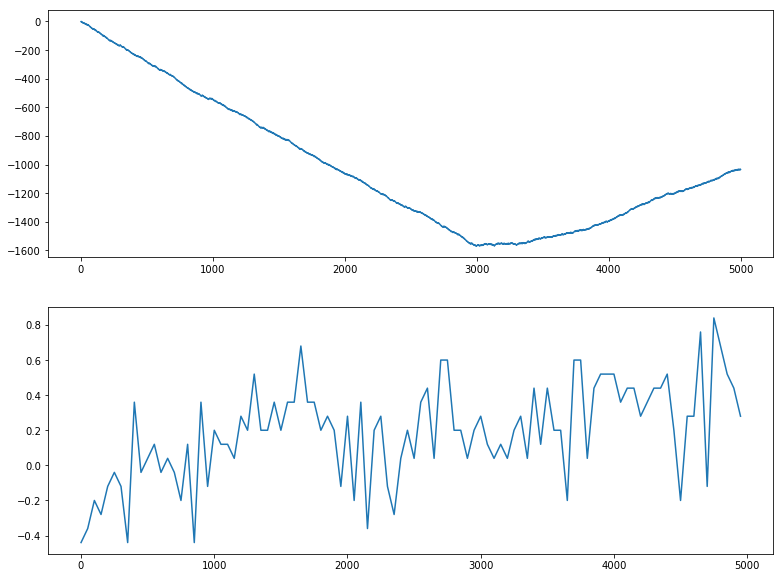

In [28]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(13, 10))
trrewards = np.array(training_rewards).cumsum()
terewards = np.array(testing_rewards)
ax[0].plot(trrewards)
ax[1].plot([x for x in range(0, 4999, 50)], terewards,)


In [101]:
[x for x in range(3100, 4999, 100)]

[3100,
 3200,
 3300,
 3400,
 3500,
 3600,
 3700,
 3800,
 3900,
 4000,
 4100,
 4200,
 4300,
 4400,
 4500,
 4600,
 4700,
 4800,
 4900]

In [31]:
history = model.history.numpy()

In [ ]:
np.savez_compressed(history)

In [41]:
tot_score = 0.0

# train over total epochs
for e in range(training_games):
    c.reset()
    model.reset_T()
    game_over = False
    # get initial input
    input_t = Tensor(c.observe(flatten=True))
    i = 0
    #iterate over each game
    while not game_over:

        # t_-1 is the previous observation
        input_tm1 = input_t.clone()
        model.update_T(state=input_tm1)

        # Randomly pick an action, or use the
        # Previously calculated action
        if (np.random.rand() <= (.5 - .5*(float(e)/training_games) )) or (model.history is None):
            action = (torch.rand(1) * (num_actions)).type(LongTensor)
        else:
            action = model.pick_action(input_tm1)


        # apply action, get rewards and new state
        reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)

        input_t = Tensor(c.observe(flatten=True))

        # store experience
        model.learn_step(next_state=input_t, action=action.cpu().numpy()[0])
       
        
        if reward != 0:
            save_t = model._sith._t.clone()
            model.update_T(state=input_t)
            model.add_memory(input_t, reward)
            tot_score += reward
            print(e, ": ", tot_score, reward)    
            model._sith._t = save_t.clone()
            model._sith._t_changed = True 

0 :  -1.0 -1
1 :  -2.0 -1
2 :  -1.0 1
3 :  -2.0 -1
4 :  -1.0 1
5 :  -2.0 -1
6 :  -3.0 -1
7 :  -4.0 -1
8 :  -3.0 1
9 :  -4.0 -1
10 :  -3.0 1
11 :  -4.0 -1
12 :  -3.0 1
13 :  -2.0 1
14 :  -3.0 -1
15 :  -2.0 1
16 :  -1.0 1
17 :  0.0 1
18 :  1.0 1
19 :  0.0 -1
20 :  -1.0 -1
21 :  0.0 1
22 :  -1.0 -1
23 :  0.0 1
24 :  -1.0 -1
25 :  -2.0 -1
26 :  -1.0 1
27 :  -2.0 -1
28 :  -3.0 -1
29 :  -4.0 -1
30 :  -5.0 -1
31 :  -6.0 -1
32 :  -5.0 1
33 :  -4.0 1
34 :  -3.0 1
35 :  -2.0 1
36 :  -3.0 -1
37 :  -2.0 1
38 :  -3.0 -1
39 :  -4.0 -1
40 :  -5.0 -1
41 :  -6.0 -1
42 :  -7.0 -1
43 :  -6.0 1
44 :  -5.0 1
45 :  -4.0 1
46 :  -5.0 -1
47 :  -4.0 1
48 :  -5.0 -1
49 :  -4.0 1
50 :  -5.0 -1
51 :  -4.0 1
52 :  -5.0 -1
53 :  -4.0 1
54 :  -5.0 -1
55 :  -6.0 -1
56 :  -7.0 -1
57 :  -8.0 -1
58 :  -7.0 1
59 :  -8.0 -1
60 :  -9.0 -1
61 :  -8.0 1
62 :  -9.0 -1
63 :  -10.0 -1
64 :  -9.0 1
65 :  -10.0 -1
66 :  -9.0 1
67 :  -10.0 -1
68 :  -11.0 -1
69 :  -12.0 -1
70 :  -13.0 -1
71 :  -14.0 -1
72 :  -15.0 -1
73 :  -16.0 -1

540 :  -11.0 -1
541 :  -12.0 -1
542 :  -11.0 1
543 :  -10.0 1
544 :  -9.0 1
545 :  -10.0 -1
546 :  -9.0 1
547 :  -8.0 1
548 :  -7.0 1
549 :  -6.0 1
550 :  -5.0 1
551 :  -4.0 1
552 :  -5.0 -1
553 :  -6.0 -1
554 :  -5.0 1
555 :  -4.0 1
556 :  -3.0 1
557 :  -2.0 1
558 :  -1.0 1
559 :  -2.0 -1
560 :  -3.0 -1
561 :  -4.0 -1
562 :  -5.0 -1
563 :  -6.0 -1
564 :  -7.0 -1
565 :  -8.0 -1
566 :  -7.0 1
567 :  -6.0 1
568 :  -5.0 1
569 :  -6.0 -1
570 :  -7.0 -1
571 :  -8.0 -1
572 :  -7.0 1
573 :  -6.0 1
574 :  -7.0 -1
575 :  -6.0 1
576 :  -7.0 -1
577 :  -8.0 -1
578 :  -7.0 1
579 :  -6.0 1
580 :  -7.0 -1
581 :  -6.0 1
582 :  -7.0 -1
583 :  -6.0 1
584 :  -7.0 -1
585 :  -8.0 -1
586 :  -7.0 1
587 :  -8.0 -1
588 :  -9.0 -1
589 :  -10.0 -1
590 :  -9.0 1
591 :  -8.0 1
592 :  -9.0 -1
593 :  -10.0 -1
594 :  -11.0 -1
595 :  -10.0 1
596 :  -9.0 1
597 :  -10.0 -1
598 :  -9.0 1
599 :  -10.0 -1
600 :  -11.0 -1
601 :  -12.0 -1
602 :  -13.0 -1
603 :  -14.0 -1
604 :  -15.0 -1
605 :  -14.0 1
606 :  -13.0 1
607 :  -1

1103 :  18.0 1
1104 :  19.0 1
1105 :  20.0 1
1106 :  21.0 1
1107 :  22.0 1
1108 :  21.0 -1
1109 :  22.0 1
1110 :  21.0 -1
1111 :  22.0 1
1112 :  21.0 -1
1113 :  22.0 1
1114 :  21.0 -1
1115 :  20.0 -1
1116 :  19.0 -1
1117 :  20.0 1
1118 :  21.0 1
1119 :  22.0 1
1120 :  21.0 -1
1121 :  20.0 -1
1122 :  21.0 1
1123 :  20.0 -1
1124 :  21.0 1
1125 :  22.0 1
1126 :  21.0 -1
1127 :  22.0 1
1128 :  21.0 -1
1129 :  20.0 -1
1130 :  19.0 -1
1131 :  20.0 1
1132 :  19.0 -1
1133 :  20.0 1
1134 :  19.0 -1
1135 :  18.0 -1
1136 :  19.0 1
1137 :  20.0 1
1138 :  21.0 1
1139 :  20.0 -1
1140 :  19.0 -1
1141 :  18.0 -1
1142 :  19.0 1
1143 :  20.0 1
1144 :  21.0 1
1145 :  22.0 1
1146 :  23.0 1
1147 :  22.0 -1
1148 :  23.0 1
1149 :  22.0 -1
1150 :  23.0 1
1151 :  22.0 -1
1152 :  23.0 1
1153 :  22.0 -1
1154 :  23.0 1
1155 :  24.0 1
1156 :  23.0 -1
1157 :  24.0 1
1158 :  23.0 -1
1159 :  22.0 -1
1160 :  21.0 -1
1161 :  20.0 -1
1162 :  19.0 -1
1163 :  20.0 1
1164 :  21.0 1
1165 :  22.0 1
1166 :  21.0 -1
1167 :  20

1634 :  101.0 1
1635 :  102.0 1
1636 :  103.0 1
1637 :  104.0 1
1638 :  103.0 -1
1639 :  104.0 1
1640 :  105.0 1
1641 :  106.0 1
1642 :  107.0 1
1643 :  106.0 -1
1644 :  107.0 1
1645 :  108.0 1
1646 :  109.0 1
1647 :  110.0 1
1648 :  111.0 1
1649 :  112.0 1
1650 :  111.0 -1
1651 :  110.0 -1
1652 :  109.0 -1
1653 :  110.0 1
1654 :  111.0 1
1655 :  112.0 1
1656 :  111.0 -1
1657 :  112.0 1
1658 :  113.0 1
1659 :  114.0 1
1660 :  115.0 1
1661 :  116.0 1
1662 :  115.0 -1
1663 :  114.0 -1
1664 :  115.0 1
1665 :  114.0 -1
1666 :  115.0 1
1667 :  114.0 -1
1668 :  115.0 1
1669 :  116.0 1
1670 :  117.0 1
1671 :  118.0 1
1672 :  119.0 1
1673 :  118.0 -1
1674 :  119.0 1
1675 :  120.0 1
1676 :  121.0 1
1677 :  122.0 1
1678 :  121.0 -1
1679 :  122.0 1
1680 :  123.0 1
1681 :  122.0 -1
1682 :  121.0 -1
1683 :  122.0 1
1684 :  123.0 1
1685 :  124.0 1
1686 :  125.0 1
1687 :  124.0 -1
1688 :  125.0 1
1689 :  124.0 -1
1690 :  125.0 1
1691 :  126.0 1
1692 :  125.0 -1
1693 :  124.0 -1
1694 :  125.0 1
1695 :

2135 :  216.0 -1
2136 :  217.0 1
2137 :  218.0 1
2138 :  219.0 1
2139 :  218.0 -1
2140 :  217.0 -1
2141 :  216.0 -1
2142 :  217.0 1
2143 :  218.0 1
2144 :  217.0 -1
2145 :  218.0 1
2146 :  217.0 -1
2147 :  216.0 -1
2148 :  217.0 1
2149 :  218.0 1
2150 :  219.0 1
2151 :  218.0 -1
2152 :  219.0 1
2153 :  218.0 -1
2154 :  217.0 -1
2155 :  218.0 1
2156 :  217.0 -1
2157 :  218.0 1
2158 :  219.0 1
2159 :  218.0 -1
2160 :  217.0 -1
2161 :  218.0 1
2162 :  219.0 1
2163 :  220.0 1
2164 :  221.0 1
2165 :  222.0 1
2166 :  223.0 1
2167 :  224.0 1
2168 :  225.0 1
2169 :  224.0 -1
2170 :  223.0 -1
2171 :  222.0 -1
2172 :  223.0 1
2173 :  222.0 -1
2174 :  223.0 1
2175 :  224.0 1
2176 :  225.0 1
2177 :  226.0 1
2178 :  227.0 1
2179 :  226.0 -1
2180 :  225.0 -1
2181 :  226.0 1
2182 :  227.0 1
2183 :  228.0 1
2184 :  227.0 -1
2185 :  226.0 -1
2186 :  227.0 1
2187 :  228.0 1
2188 :  229.0 1
2189 :  230.0 1
2190 :  231.0 1
2191 :  232.0 1
2192 :  233.0 1
2193 :  234.0 1
2194 :  235.0 1
2195 :  234.0 -1
21

2636 :  355.0 1
2637 :  354.0 -1
2638 :  353.0 -1
2639 :  352.0 -1
2640 :  353.0 1
2641 :  354.0 1
2642 :  355.0 1
2643 :  354.0 -1
2644 :  353.0 -1
2645 :  354.0 1
2646 :  355.0 1
2647 :  356.0 1
2648 :  357.0 1
2649 :  356.0 -1
2650 :  355.0 -1
2651 :  356.0 1
2652 :  357.0 1
2653 :  358.0 1
2654 :  359.0 1
2655 :  360.0 1
2656 :  361.0 1
2657 :  360.0 -1
2658 :  361.0 1
2659 :  362.0 1
2660 :  363.0 1
2661 :  362.0 -1
2662 :  363.0 1
2663 :  364.0 1
2664 :  365.0 1
2665 :  366.0 1
2666 :  365.0 -1
2667 :  364.0 -1
2668 :  363.0 -1
2669 :  362.0 -1
2670 :  363.0 1
2671 :  364.0 1
2672 :  363.0 -1
2673 :  364.0 1
2674 :  365.0 1
2675 :  366.0 1
2676 :  367.0 1
2677 :  368.0 1
2678 :  369.0 1
2679 :  370.0 1
2680 :  371.0 1
2681 :  370.0 -1
2682 :  369.0 -1
2683 :  370.0 1
2684 :  371.0 1
2685 :  370.0 -1
2686 :  369.0 -1
2687 :  370.0 1
2688 :  369.0 -1
2689 :  370.0 1
2690 :  371.0 1
2691 :  370.0 -1
2692 :  371.0 1
2693 :  372.0 1
2694 :  373.0 1
2695 :  372.0 -1
2696 :  373.0 1
269

3137 :  494.0 1
3138 :  495.0 1
3139 :  494.0 -1
3140 :  495.0 1
3141 :  496.0 1
3142 :  497.0 1
3143 :  498.0 1
3144 :  497.0 -1
3145 :  496.0 -1
3146 :  497.0 1
3147 :  498.0 1
3148 :  499.0 1
3149 :  500.0 1
3150 :  501.0 1
3151 :  502.0 1
3152 :  503.0 1
3153 :  504.0 1
3154 :  505.0 1
3155 :  504.0 -1
3156 :  505.0 1
3157 :  504.0 -1
3158 :  505.0 1
3159 :  506.0 1
3160 :  507.0 1
3161 :  508.0 1
3162 :  509.0 1
3163 :  510.0 1
3164 :  509.0 -1
3165 :  510.0 1
3166 :  511.0 1
3167 :  512.0 1
3168 :  513.0 1
3169 :  514.0 1
3170 :  513.0 -1
3171 :  512.0 -1
3172 :  511.0 -1
3173 :  512.0 1
3174 :  513.0 1
3175 :  514.0 1
3176 :  515.0 1
3177 :  516.0 1
3178 :  517.0 1
3179 :  518.0 1
3180 :  517.0 -1
3181 :  516.0 -1
3182 :  517.0 1
3183 :  518.0 1
3184 :  519.0 1
3185 :  520.0 1
3186 :  519.0 -1
3187 :  518.0 -1
3188 :  519.0 1
3189 :  518.0 -1
3190 :  519.0 1
3191 :  520.0 1
3192 :  521.0 1
3193 :  522.0 1
3194 :  521.0 -1
3195 :  522.0 1
3196 :  521.0 -1
3197 :  522.0 1
3198 :  

3640 :  695.0 1
3641 :  696.0 1
3642 :  697.0 1
3643 :  698.0 1
3644 :  697.0 -1
3645 :  696.0 -1
3646 :  697.0 1
3647 :  696.0 -1
3648 :  697.0 1
3649 :  696.0 -1
3650 :  697.0 1
3651 :  698.0 1
3652 :  697.0 -1
3653 :  696.0 -1
3654 :  697.0 1
3655 :  696.0 -1
3656 :  695.0 -1
3657 :  696.0 1
3658 :  695.0 -1
3659 :  696.0 1
3660 :  697.0 1
3661 :  696.0 -1
3662 :  697.0 1
3663 :  696.0 -1
3664 :  697.0 1
3665 :  696.0 -1
3666 :  697.0 1
3667 :  698.0 1
3668 :  697.0 -1
3669 :  698.0 1
3670 :  699.0 1
3671 :  700.0 1
3672 :  701.0 1
3673 :  702.0 1
3674 :  701.0 -1
3675 :  702.0 1
3676 :  701.0 -1
3677 :  702.0 1
3678 :  701.0 -1
3679 :  702.0 1
3680 :  703.0 1
3681 :  704.0 1
3682 :  705.0 1
3683 :  706.0 1
3684 :  707.0 1
3685 :  708.0 1
3686 :  707.0 -1
3687 :  708.0 1
3688 :  709.0 1
3689 :  710.0 1
3690 :  711.0 1
3691 :  712.0 1
3692 :  713.0 1
3693 :  714.0 1
3694 :  715.0 1
3695 :  716.0 1
3696 :  717.0 1
3697 :  718.0 1
3698 :  717.0 -1
3699 :  718.0 1
3700 :  719.0 1
3701 :

4145 :  960.0 -1
4146 :  961.0 1
4147 :  962.0 1
4148 :  961.0 -1
4149 :  962.0 1
4150 :  961.0 -1
4151 :  962.0 1
4152 :  963.0 1
4153 :  964.0 1
4154 :  965.0 1
4155 :  966.0 1
4156 :  967.0 1
4157 :  966.0 -1
4158 :  967.0 1
4159 :  968.0 1
4160 :  969.0 1
4161 :  968.0 -1
4162 :  969.0 1
4163 :  970.0 1
4164 :  971.0 1
4165 :  972.0 1
4166 :  973.0 1
4167 :  974.0 1
4168 :  975.0 1
4169 :  976.0 1
4170 :  975.0 -1
4171 :  976.0 1
4172 :  977.0 1
4173 :  978.0 1
4174 :  977.0 -1
4175 :  976.0 -1
4176 :  977.0 1
4177 :  978.0 1
4178 :  977.0 -1
4179 :  978.0 1
4180 :  979.0 1
4181 :  980.0 1
4182 :  979.0 -1
4183 :  980.0 1
4184 :  981.0 1
4185 :  982.0 1
4186 :  981.0 -1
4187 :  982.0 1
4188 :  983.0 1
4189 :  984.0 1
4190 :  985.0 1
4191 :  986.0 1
4192 :  987.0 1
4193 :  988.0 1
4194 :  989.0 1
4195 :  990.0 1
4196 :  989.0 -1
4197 :  988.0 -1
4198 :  987.0 -1
4199 :  988.0 1
4200 :  987.0 -1
4201 :  988.0 1
4202 :  989.0 1
4203 :  990.0 1
4204 :  989.0 -1
4205 :  990.0 1
4206 :  

4625 :  1214.0 -1
4626 :  1213.0 -1
4627 :  1214.0 1
4628 :  1215.0 1
4629 :  1216.0 1
4630 :  1217.0 1
4631 :  1218.0 1
4632 :  1219.0 1
4633 :  1220.0 1
4634 :  1221.0 1
4635 :  1222.0 1
4636 :  1223.0 1
4637 :  1224.0 1
4638 :  1225.0 1
4639 :  1226.0 1
4640 :  1227.0 1
4641 :  1226.0 -1
4642 :  1227.0 1
4643 :  1226.0 -1
4644 :  1227.0 1
4645 :  1228.0 1
4646 :  1227.0 -1
4647 :  1228.0 1
4648 :  1229.0 1
4649 :  1230.0 1
4650 :  1231.0 1
4651 :  1232.0 1
4652 :  1233.0 1
4653 :  1234.0 1
4654 :  1233.0 -1
4655 :  1234.0 1
4656 :  1235.0 1
4657 :  1236.0 1
4658 :  1237.0 1
4659 :  1238.0 1
4660 :  1239.0 1
4661 :  1238.0 -1
4662 :  1239.0 1
4663 :  1240.0 1
4664 :  1241.0 1
4665 :  1240.0 -1
4666 :  1239.0 -1
4667 :  1240.0 1
4668 :  1241.0 1
4669 :  1242.0 1
4670 :  1243.0 1
4671 :  1244.0 1
4672 :  1245.0 1
4673 :  1246.0 1
4674 :  1247.0 1
4675 :  1248.0 1
4676 :  1249.0 1
4677 :  1250.0 1
4678 :  1249.0 -1
4679 :  1250.0 1
4680 :  1251.0 1
4681 :  1252.0 1
4682 :  1253.0 1
4683

In [42]:
tot_score = 0.0

# train over total epochs
for e in range(1000):
    c.reset()
    model.reset_T()
    game_over = False
    # get initial input
    input_t = Tensor(c.observe(flatten=True))
    i = 0
    #iterate over each game
    while not game_over:
    #while i < 100:
        # t_-1 is the previous observation
        input_tm1 = input_t.clone()
        model.update_T(state=input_tm1)

        # Randomly pick an action, or use the
        # Previously calculated action
        action = model.pick_action(input_tm1)

        # apply action, get rewards and new state
        reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)
        
        input_t = Tensor(c.observe(flatten=True))

        # store experience
        model.learn_step(next_state=input_t, action=action.cpu().numpy()[0])
        
        if reward != 0:
            tot_score += reward
            print(e, ": ", tot_score, reward)    
          
    # Reset Game and Model Queue when the game is over.
print(tot_score / 1000.)

0 :  1.0 1
1 :  2.0 1
2 :  3.0 1
3 :  4.0 1
4 :  5.0 1
5 :  6.0 1
6 :  7.0 1
7 :  8.0 1
8 :  9.0 1
9 :  10.0 1
10 :  11.0 1
11 :  12.0 1
12 :  13.0 1
13 :  14.0 1
14 :  15.0 1
15 :  16.0 1
16 :  17.0 1
17 :  18.0 1
18 :  17.0 -1
19 :  18.0 1
20 :  19.0 1
21 :  20.0 1
22 :  21.0 1
23 :  22.0 1
24 :  23.0 1
25 :  24.0 1
26 :  25.0 1
27 :  26.0 1
28 :  27.0 1
29 :  28.0 1
30 :  29.0 1
31 :  28.0 -1
32 :  27.0 -1
33 :  28.0 1
34 :  27.0 -1
35 :  28.0 1
36 :  27.0 -1
37 :  28.0 1
38 :  29.0 1
39 :  30.0 1
40 :  31.0 1
41 :  32.0 1
42 :  31.0 -1
43 :  32.0 1
44 :  33.0 1
45 :  32.0 -1
46 :  33.0 1
47 :  34.0 1
48 :  33.0 -1
49 :  34.0 1
50 :  35.0 1
51 :  36.0 1
52 :  37.0 1
53 :  38.0 1
54 :  37.0 -1
55 :  36.0 -1
56 :  37.0 1
57 :  38.0 1
58 :  39.0 1
59 :  40.0 1
60 :  41.0 1
61 :  42.0 1
62 :  43.0 1
63 :  44.0 1
64 :  45.0 1
65 :  46.0 1
66 :  45.0 -1
67 :  46.0 1
68 :  47.0 1
69 :  46.0 -1
70 :  47.0 1
71 :  48.0 1
72 :  49.0 1
73 :  50.0 1
74 :  51.0 1
75 :  52.0 1
76 :  53.0 1
77 :  

558 :  333.0 1
559 :  332.0 -1
560 :  333.0 1
561 :  334.0 1
562 :  335.0 1
563 :  336.0 1
564 :  337.0 1
565 :  338.0 1
566 :  339.0 1
567 :  338.0 -1
568 :  339.0 1
569 :  340.0 1
570 :  341.0 1
571 :  342.0 1
572 :  343.0 1
573 :  342.0 -1
574 :  343.0 1
575 :  344.0 1
576 :  345.0 1
577 :  346.0 1
578 :  347.0 1
579 :  348.0 1
580 :  349.0 1
581 :  350.0 1
582 :  349.0 -1
583 :  348.0 -1
584 :  349.0 1
585 :  350.0 1
586 :  351.0 1
587 :  352.0 1
588 :  353.0 1
589 :  354.0 1
590 :  355.0 1
591 :  356.0 1
592 :  357.0 1
593 :  356.0 -1
594 :  355.0 -1
595 :  354.0 -1
596 :  355.0 1
597 :  356.0 1
598 :  357.0 1
599 :  358.0 1
600 :  359.0 1
601 :  358.0 -1
602 :  359.0 1
603 :  360.0 1
604 :  361.0 1
605 :  360.0 -1
606 :  361.0 1
607 :  362.0 1
608 :  363.0 1
609 :  364.0 1
610 :  365.0 1
611 :  364.0 -1
612 :  365.0 1
613 :  366.0 1
614 :  367.0 1
615 :  368.0 1
616 :  369.0 1
617 :  370.0 1
618 :  371.0 1
619 :  372.0 1
620 :  373.0 1
621 :  374.0 1
622 :  375.0 1
623 :  376.0 1

In [ ]:
print("Creating animation...")
plt.style.use('classic')
i = 0

def animate(mat):
    global i
    i+=1
    print(i)
    return plt.imshow(mat, cmap='gray', interpolation='none'),

fig=plt.figure()
#anim = animation.FuncAnimation(fig, animate, frames = frames_stack[0:2], interval=(1.0/30.0)*1000, blit=True)
anim = animation.FuncAnimation(fig, animate, frames = frames_stack[51:102], interval=(1.0/30.0)*1000*5, blit=True)
rc('animation', html='html5')
HTML(anim.to_html5_video())

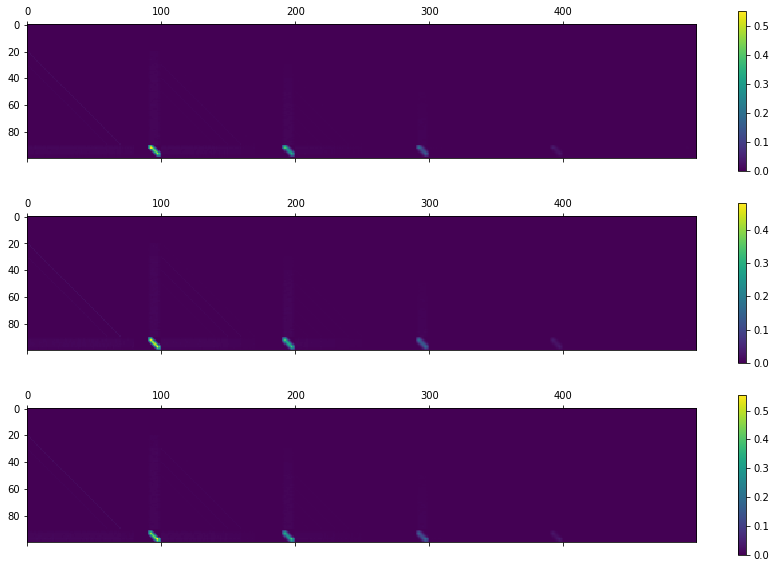

In [95]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(15,10))
tt = ax1.matshow(model._M[0].cpu().numpy())
fig.colorbar(tt, ax=ax1)
tt = ax2.matshow(model._M[1].cpu().numpy())
fig.colorbar(tt, ax=ax2)
tt = ax3.matshow(model._M[2].cpu().numpy())
fig.colorbar(tt, ax=ax3)


In [96]:
l1_normalized = torch.zeros(model._action_len,
                              model._state_len,
                              model._sith.tau_star[model._sith._T_full_ind].size-1,
                              model._in_sith).type(FloatTensor)

for i in range(model._action_len):
    l1_normalized[i] = model._M[i].view(model._state_len,
                                  model._sith.tau_star[model._sith._T_full_ind].size-1,
                                  model._in_sith)

    denom = torch.abs(l1_normalized[i]).sum(0).unsqueeze(0)
    denom[denom == 0.0] = 1.0
    normalized = l1_normalized[i]/denom.expand_as(l1_normalized[i])
    l1_normalized[i] = normalized
l1_normalized = l1_normalized.view(model._action_len, model._state_len, (model._sith.tau_star[model._sith._T_full_ind].size-1)*model._in_sith)


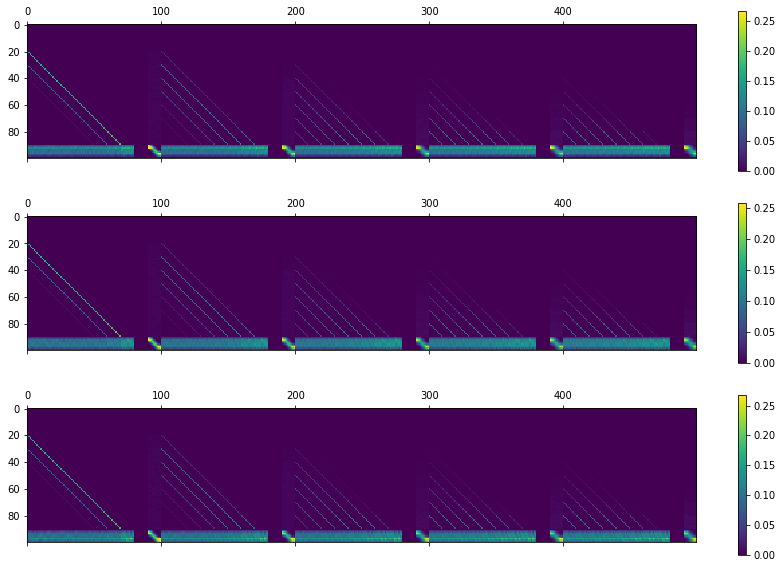

In [97]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(15,10))
tt = ax1.matshow(l1_normalized[0].cpu().numpy())
fig.colorbar(tt, ax=ax1)
tt = ax2.matshow(l1_normalized[1].cpu().numpy())
fig.colorbar(tt, ax=ax2)
tt = ax3.matshow(l1_normalized[2].cpu().numpy())
fig.colorbar(tt, ax=ax3)


In [480]:
model._sith.tau_star[model._sith._T_full_ind]

array([ 0.02276712,  0.04880333,  0.10461428,  0.22425   ,  0.48069978,
        1.03042269], dtype=float32)

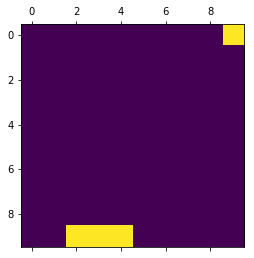

In [149]:
c.reset()
model.reset_T()
input_t = Tensor(c.observe(flatten=True))
matshow(input_t.view(10,10).cpu().numpy())

[ 1.]


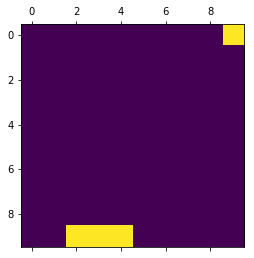

In [150]:
 # t_-1 is the previous observation
input_tm1 = input_t.clone()


# Randomly pick an action, or use the
# Previously calculated action
#if (np.random.rand() <= per_random_act) or (model.history is None):

action = torch.zeros(1).type(FloatTensor)
action[0] = 1

# apply action, get rewards and new state
reward, timestep, game_over = c.act(action.cpu().numpy()[0]-1)

# t_0, current timestep
input_t = Tensor(c.observe(flatten=True))

# store experience
#model.learn_step(state=input_tm1, action=action.cpu().numpy()[0])
model.update_T(state=input_tm1)
print(action.cpu().numpy())
if reward != 0:
    #save_t = model._sith._t.clone()
    #model.update_T(state=input_t)
    #model.add_memory(reward)
    tot_score += reward
    print(e, ": ", tot_score, reward)
    #model._sith._t = save_t.clone()
    #model._sith._t_changed = True
matshow(model._sith.T[:100].view(10,10).cpu().numpy())

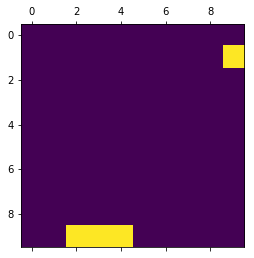

In [151]:
matshow(input_t.view(10,10).cpu().numpy())

In [152]:

num_decays = 20

state = input_t.clone()
# Compress Histories (WHY DO I HAVE TO SUBTRACT 1 FROM THE SIZE OF TAUSTAR?????)
h = model.history[:, 100:-1].clone()

pfr_csum = torch.zeros(model.history.size(0)).type(FloatTensor)
pfr_list = None
pfr_csum_list = None
# Save our rards for later
rewards = model.history[:,-1]

# Save t
save_t = model._sith._t.clone()

model._sith.update_t(state*model._dt, dur=model._dur)
model._sith.update_t(item=None, dur=model._delay)
# Loop over actions
for i in range(num_decays):
    # Input new state+action into SITH
    pe = h - model._sith.T.view(1, -1).expand_as(h)
    # Sum all the positive prediction error and negative predition error
    #print(((pe*(pe>0).type(FloatTensor))).sum(1), (-20)*(pe*(pe<0).type(FloatTensor)).sum(1))
    w = 1./(1.+((1*(pe*(pe>0).type(FloatTensor))).sum(1) + (-100)*(pe*(pe<0).type(FloatTensor)).sum(1)))
    # Multiply w by the reward and sum all values together. Add to the list of potential action rewards
    
    pfr_csum += w*rewards
    if pfr_list is None:
        pfr_list = (w*rewards).clone().view(1, -1)
        pfr_csum_list = (w*rewards).clone().view(1, -1)
    else:
        pfr_list = torch.cat((pfr_list, (w*rewards).clone().view(1, -1)), 0)
        pfr_csum_list = torch.cat((pfr_csum_list, pfr_csum.clone().view(1, -1)), 0)
        
    model._sith.update_t(item=None, dur=model._delay+model._dt)

# return back to previous t
model._sith._t = save_t
model._sith._t_changed = True


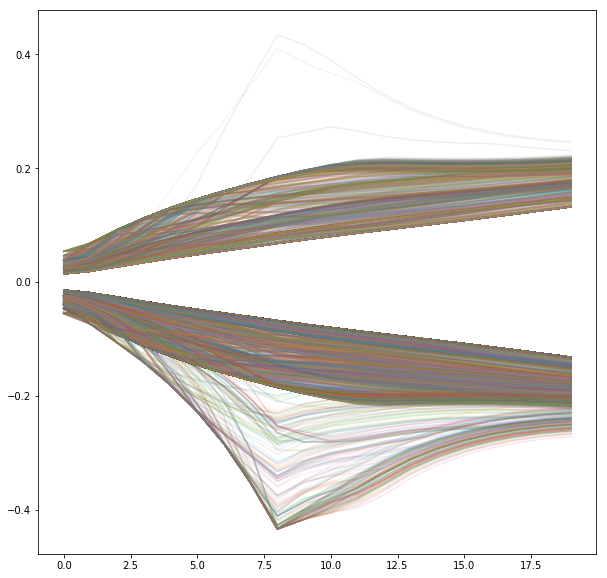

In [153]:
fig, ax = plt.subplots(figsize=(10,10))
a = plot(pfr_list.cpu().numpy(), alpha=.1);


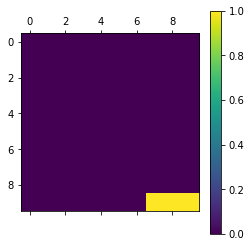

In [154]:
matshow(model.history[pfr_list.cpu().numpy().sum(0).argmax(), :100].view(10,10).cpu().numpy())
colorbar()

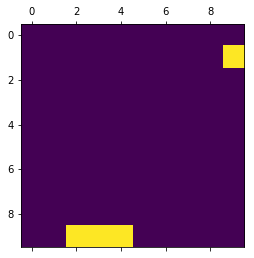

In [155]:
matshow(input_t.view(10,10).cpu().numpy())

In [156]:

state = input_t.clone()
upd_pfr_list = pfr_list/pfr_list.sum(0).expand_as(pfr_list)

a = model.history[pfr_list.cpu().numpy().sum(0).argmax(), :-1]
a = a.view(6, 100)
a = a[0].clone()
a = a.view(-1)

pos = [0, 1, 3, 7, 15]

#RIGHT
choice = 2
tot = 0.0

sal_p = torch.cat((state, torch.zeros((model._sith.T.size(0) - state.size(0), 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*1, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*2, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*3, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*4, 1)).type(FloatTensor), state), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]

print("r", sqrt(tot))  


#LEFT
choice = 0
tot = 0.0

sal_p = torch.cat((state, torch.zeros((model._sith.T.size(0) - state.size(0), 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*1, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*2, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*3, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*4, 1)).type(FloatTensor), state), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]

print("l", sqrt(tot))  

# DONT MOVE
choice = 1
tot = 0.0

sal_p = torch.cat((state, torch.zeros((model._sith.T.size(0) - state.size(0), 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*1, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*2, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*3, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()]
sal_p = torch.cat((torch.zeros((state.size(0)*4, 1)).type(FloatTensor), state), 0)
ssl = l1_normalized[choice].mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]

print("n", sqrt(tot))

r 0.693247581076
l 0.812113940114
n 0.750091642901


In [503]:
actions = torch.eye(3).type(FloatTensor)

sa_l = torch.cat((torch.zeros(100).type(FloatTensor), actions[0]), 0)
sa_r = torch.cat((torch.zeros(100).type(FloatTensor), actions[2]), 0)
sa_n = torch.cat((torch.zeros(100).type(FloatTensor), actions[1]), 0)
sa_0 = torch.cat((input_t, torch.zeros(3).type(FloatTensor)), 0)

upd_pfr_list = pfr_list/pfr_list.sum(0).expand_as(pfr_list)

a = model.history[pfr_list.cpu().numpy().sum(0).argmax(), :-1]
a = a.view(6, 103)
a = a[0, :-3].clone()
a = a.view(-1)

pos = [0, 1, 3, 7, 15]
ind = argmax([upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()],upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()], 
           upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()],upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()],
           upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]])
print(ind)
sal = sa_r
tot = 0.0

sa0_p = torch.cat((sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0), 1)).type(FloatTensor)), 0)
sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa0.size(0)*1, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*2, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0)*3, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*3, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0)*4, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*4, 1)).type(FloatTensor), sa_0), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]

print("r", tot)  


sal = sa_l
tot = 0.0

sa0_p = torch.cat((sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0), 1)).type(FloatTensor)), 0)
sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa0.size(0)*1, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*2, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0)*3, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*3, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0)*4, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*4, 1)).type(FloatTensor), sa_0), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]

print("l", tot)  
sal = sa_n
tot = 0.0

sa0_p = torch.cat((sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0), 1)).type(FloatTensor)), 0)
sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa0.size(0)*1, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*2, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0)*3, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*3, 1)).type(FloatTensor), sa_0, torch.zeros((model._sith.T.size(0) - sa_0.size(0)*4, 1)).type(FloatTensor)), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()]
sa0_p = torch.cat((torch.zeros((sa_0.size(0)*4, 1)).type(FloatTensor), sa_0), 0)
sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))*upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]

print("n", tot) 



3
r 0.5113942600930175
l 0.49334393067350835
n 0.5023862782115565


In [478]:
actions = torch.eye(3).type(FloatTensor)

sa_l = torch.cat((input_t, actions[0]), 0)
sa_n = torch.cat((input_t, actions[1]), 0)
sa_r = torch.cat((input_t, actions[2]), 0)
upd_pfr_list = pfr_list/pfr_list.sum(0).expand_as(pfr_list)

a = model.history[pfr_list.cpu().numpy().sum(0).argmax(), :-1]
a = a.view(6, 103)
a = a[0, :-3].clone()
a = a.view(-1)

pos = [0, 1, 3, 7, 15]
ind = argmax([upd_pfr_list[0, pfr_list.cpu().numpy().sum(0).argmax()],upd_pfr_list[1, pfr_list.cpu().numpy().sum(0).argmax()], 
           upd_pfr_list[3, pfr_list.cpu().numpy().sum(0).argmax()],upd_pfr_list[7, pfr_list.cpu().numpy().sum(0).argmax()],
           upd_pfr_list[15, pfr_list.cpu().numpy().sum(0).argmax()]])
print(ind)
sal = sa_r
tot = 0.0

sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
print("r", tot)  


sal = sa_l
tot = 0.0

sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))

print("l", tot)  
sal = sa_n
tot = 0.0

sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))
sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = normalized.mm(sal_p).unsqueeze(0)
tot += ((ssl.view(-1) - a).dot((ssl.view(-1) - a)))

print("n", tot) 



3
r 6.024967074394226
l 5.562493026256561
n 5.780050039291382


In [105]:
sar = torch.cat((input_t, actions[2]), 0)

sar_p = torch.cat((sar, torch.zeros((model._sith.T.size(0) - sar.size(0), 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p).unsqueeze(0)
sar_p = torch.cat((torch.zeros((sar.size(0)*1, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sar.size(0)*2, 1)).type(FloatTensor)), 0)
ssr = torch.cat((ssr, normalized.mm(sar_p).unsqueeze(0)), 0)
sar_p = torch.cat((torch.zeros((sar.size(0)*2, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sar.size(0)*3, 1)).type(FloatTensor)), 0)
ssr = torch.cat((ssr, normalized.mm(sar_p).unsqueeze(0)), 0)
sar_p = torch.cat((torch.zeros((sar.size(0)*3, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sar.size(0)*4, 1)).type(FloatTensor)), 0)
ssr = torch.cat((ssr, normalized.mm(sar_p).unsqueeze(0)), 0)
sar_p = torch.cat((torch.zeros((sar.size(0)*4, 1)).type(FloatTensor), sar), 0)
ssr = torch.cat((ssr, normalized.mm(sar_p).unsqueeze(0)), 0)



a = model.history[pfr_list.cpu().numpy().sum(0).argmax(), :-1]
a = a.view(5, 103)
a = a[:, :-3].clone()
a = a.view(-1)

ssr.view(-1).dot(a)

0.8026248216629028

TypeError: size received an invalid combination of arguments - got (int, int), but expected one of:
 * (int dim)
 * no arguments


't2 = ax3.matshow(ssr, clim=(climMin, climMax))\nfig.colorbar(t2, ax=ax2)\n\nax3.set_title("RIGHT")\n\nt3 = ax4.matshow((ssl-ssr)[:, :])\nfig.colorbar(t3, ax=ax4)\n\nax4.set_title("DIFF")'

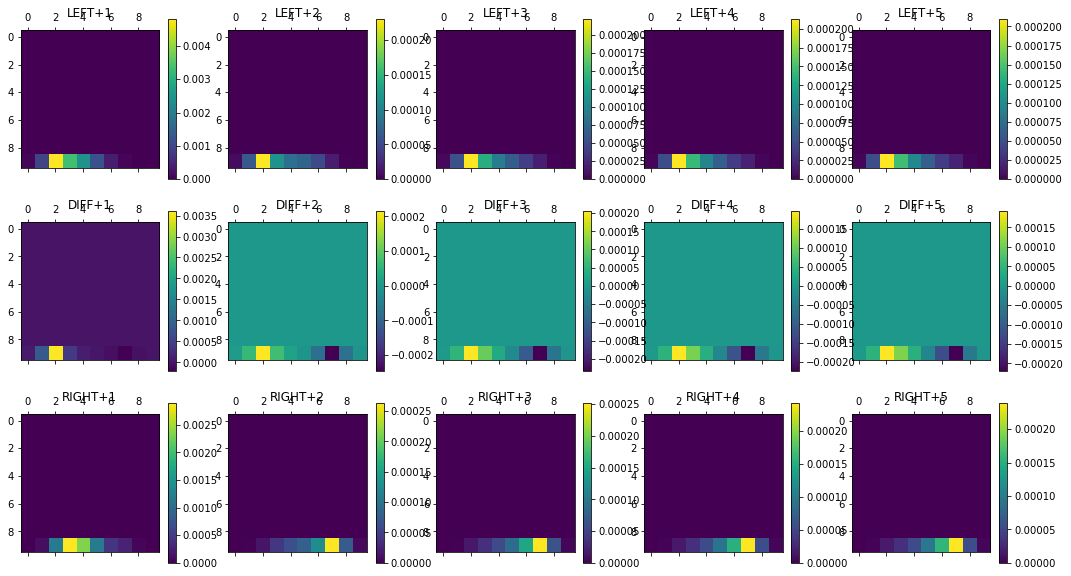

In [501]:
actions = torch.eye(3).type(FloatTensor)

plt.close('all')
fig, ((ax1, ax2, ax3, ax4, ax5), (ax1d, ax2d, ax3d, ax4d, ax5d), (ax1b, ax2b, ax3b, ax4b, ax5b)) = plt.subplots(nrows=3, ncols=5, figsize=(18,10))

sal = torch.cat((torch.zeros(100).type(FloatTensor), actions[0]), 0)
sar = torch.cat((torch.zeros(100).type(FloatTensor), actions[2]), 0)
san = torch.cat((torch.zeros(100).type(FloatTensor), actions[1]), 0)
sa0 = torch.cat((input_t, torch.zeros(3).type(FloatTensor)), 0)

"""save_t = model._sith._t.clone()
model._sith.update_t(sal*model._dt, dur=model._dur)
model._sith.update_t(item=None, dur=model._delay)
"""
#first taustar 
sa0_p = torch.cat((sa0, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)

sal_p = torch.cat((sal, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssl = (normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1))*normalized.mm(sal_p).view(-1) * normalized.mm(sa0_p).view(-1)
t1 = ax1.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax1)
ax1.set_title("LEFT+1")
sar_p = torch.cat((sar, torch.zeros((model._sith.T.size(0) - sal.size(0), 1)).type(FloatTensor)), 0)
ssr = (normalized.mm(sar_p).view(-1) * normalized.mm(sa0_p).view(-1)) * (normalized.mm(sar_p).view(-1) * normalized.mm(sa0_p).view(-1))
t1 = ax1b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax1b)
ax1b.set_title("RIGHT+1")
t1 = ax1d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax1d)
ax1d.set_title("DIFF+1")

sa0_p = torch.cat((torch.zeros((sa0.size(0)*1, 1)).type(FloatTensor), sa0, torch.zeros((model._sith.T.size(0) - sa0.size(0)*2, 1)).type(FloatTensor)), 0)

sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)*normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)
t1 = ax2.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax2)
ax2.set_title("LEFT+2")
sar_p = torch.cat((torch.zeros((sar.size(0)*1, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)*normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)
t1 = ax2b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax2b)
ax2b.set_title("RIGHT+2")
t1 = ax2d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax2d)
ax2d.set_title("DIFF+2")

sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)*normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)
t1 = ax3.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax3)
ax3.set_title("LEFT+3")
sar_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)*normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)
t1 = ax3b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax3b)
ax3b.set_title("RIGHT+3")
t1 = ax3d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax3d)
ax3d.set_title("DIFF+3")

sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)*normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)
t1 = ax4.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax4)
ax4.set_title("LEFT+4")
sar_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)*normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)
t1 = ax4b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax4b)
ax4b.set_title("RIGHT+4")
t1 = ax4d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax4d)
ax4d.set_title("DIFF+4")

sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)*normalized.mm(sal_p).view(-1) * normalized.mm(sal_p).view(-1)
t1 = ax5.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax5)
ax5.set_title("LEFT+5")
sar_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sar), 0)
ssr = normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)*normalized.mm(sar_p).view(-1) * normalized.mm(sar_p).view(-1)
t1 = ax5b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax5b)
ax5b.set_title("RIGHT+5")
t1 = ax5d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax5d)
ax5d.set_title("DIFF+5")


"""t2 = ax3.matshow(ssr, clim=(climMin, climMax))
fig.colorbar(t2, ax=ax2)

ax3.set_title("RIGHT")

t3 = ax4.matshow((ssl-ssr)[:, :])
fig.colorbar(t3, ax=ax4)

ax4.set_title("DIFF")"""


Text(0.5,1.05,'DIFF')

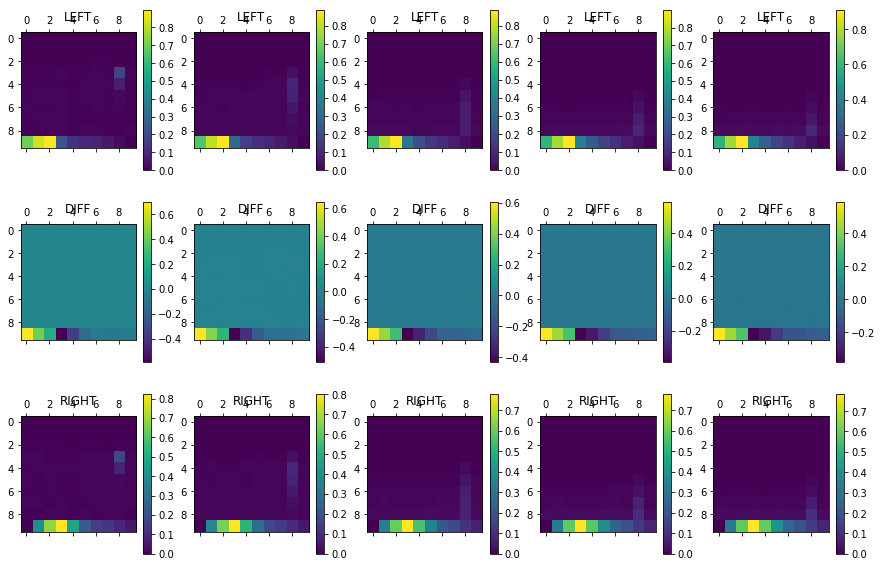

In [126]:
fig, ((axl1, axl2, axl3, axl4, axl5), (axd1, axd2, axd3, axd4, axd5), (axr1, axr2, axr3, axr4, axr5)) = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))
sal_p = torch.cat((state, torch.zeros((model._sith.T.size(0) - state.size(0), 1)).type(FloatTensor)), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl1.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl1)
axl1.set_title("LEFT")
ssr = l1_normalized[2].mm(sal_p)
t1 = axr1.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr1)
axr1.set_title("RIGHT")
t1 = axd1.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd1)
axd1.set_title("DIFF")

sal_p = torch.cat((torch.zeros((state.size(0)*1, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl2.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl2)
axl2.set_title("LEFT")
ssr = l1_normalized[2].mm(sal_p)
t1 = axr2.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr2)
axr2.set_title("RIGHT")
t1 = axd2.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd2)
axd2.set_title("DIFF")

sal_p = torch.cat((torch.zeros((state.size(0)*2, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl3.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl3)
axl3.set_title("LEFT")
ssr = l1_normalized[2].mm(sal_p)
t1 = axr3.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr3)
axr3.set_title("RIGHT")
t1 = axd3.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd3)
axd3.set_title("DIFF")

sal_p = torch.cat((torch.zeros((state.size(0)*3, 1)).type(FloatTensor), state, torch.zeros((model._sith.T.size(0) - state.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl4.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl4)
axl4.set_title("LEFT")
ssr = l1_normalized[2].mm(sal_p)
t1 = axr4.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr4)
axr4.set_title("RIGHT")
t1 = axd4.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd4)
axd4.set_title("DIFF")

sal_p = torch.cat((torch.zeros((state.size(0)*4, 1)).type(FloatTensor),state), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl5.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl5)
axl5.set_title("LEFT")
ssr = l1_normalized[2].mm(sal_p)
t1 = axr5.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr5)
axr5.set_title("RIGHT")
t1 = axd5.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd5)
axd5.set_title("DIFF")


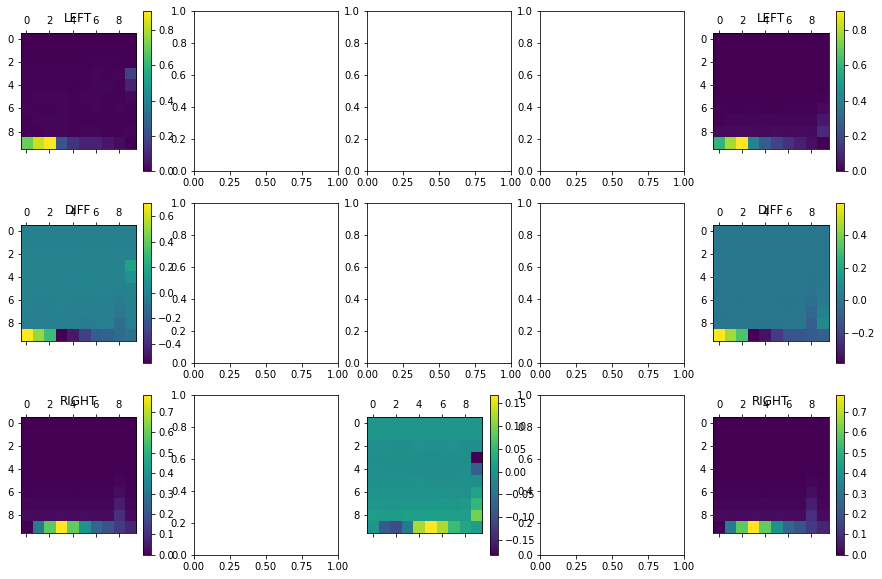

In [145]:
fig, ((axl1, axl2, axl3, axl4, axl5), (axd1, axd2, axd3, axd4, axd5), (axr1, axr2, axr3, axr4, axr5)) = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))
sal_p = torch.cat((state, torch.zeros((model._sith.T.size(0) - state.size(0), 1)).type(FloatTensor)), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl1.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl1)
axl1.set_title("LEFT")
ssr1 = l1_normalized[2].mm(sal_p)
t1 = axr1.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr1)
axr1.set_title("RIGHT")
t1 = axd1.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd1)
axd1.set_title("DIFF")

sal_p = torch.cat((torch.zeros((state.size(0)*4, 1)).type(FloatTensor),state), 0)
ssl = l1_normalized[0].mm(sal_p)
t1 = axl5.matshow(ssl.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axl5)
axl5.set_title("LEFT")
ssr2 = l1_normalized[2].mm(sal_p)
t1 = axr5.matshow(ssr.view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr5)
axr5.set_title("RIGHT")
t1 = axd5.matshow((ssl - ssr).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axd5)
axd5.set_title("DIFF")

t1 = axr3.matshow((ssr2 - ssr1).view(10,10).cpu().numpy());
fig.colorbar(t1, ax=axr3)


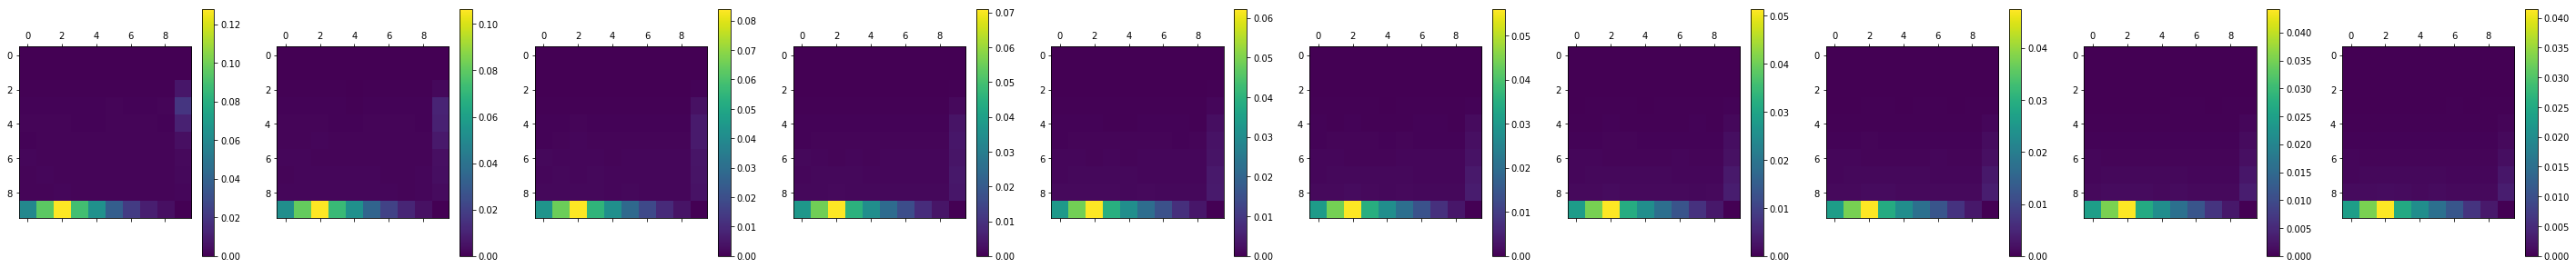

In [173]:
save_t = model._sith._t.clone()
fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(50,5))
state = input_t
for i in range(10):
    model._sith.update_t(state*model._dt, dur=model._dur)
    model._sith.update_t(item=None, dur=model._delay)

    ssl = l1_normalized[0].mm(model._sith.T.view(-1, 1))
    f = ax[i].matshow(ssl.view(10,10).cpu().numpy())
    state = ssl.view(-1).clone()
    fig.colorbar(f, ax=ax[i])
    
model._sith._t = save_t.clone()
    


In [165]:
model._sith._t = save_t.clone()


't2 = ax3.matshow(ssr, clim=(climMin, climMax))\nfig.colorbar(t2, ax=ax2)\n\nax3.set_title("RIGHT")\n\nt3 = ax4.matshow((ssl-ssr)[:, :])\nfig.colorbar(t3, ax=ax4)\n\nax4.set_title("DIFF")'

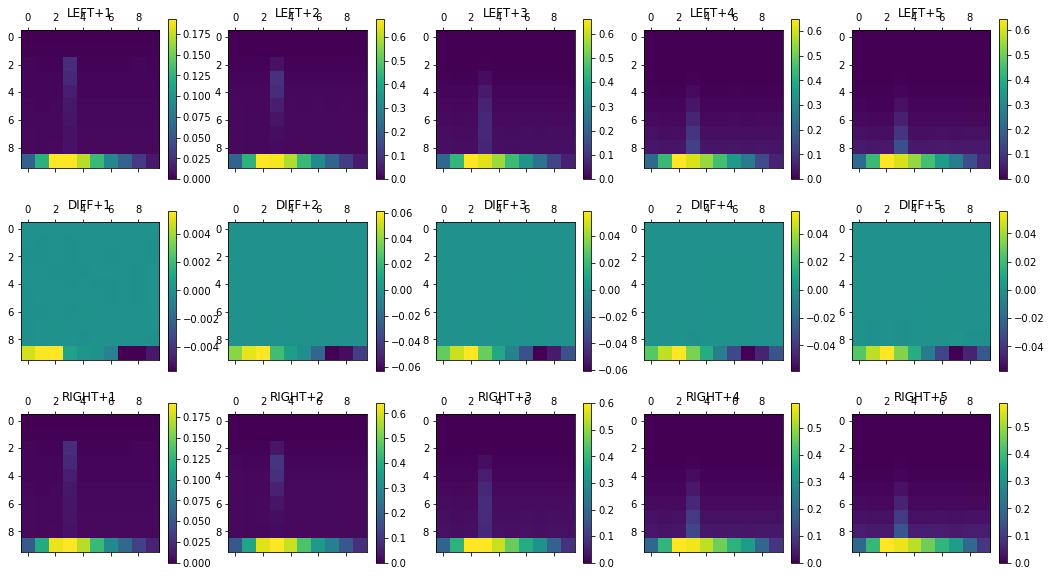

In [483]:
actions = torch.eye(3).type(FloatTensor)

plt.close('all')
fig, ((ax1, ax2, ax3, ax4, ax5), (ax1d, ax2d, ax3d, ax4d, ax5d), (ax1b, ax2b, ax3b, ax4b, ax5b)) = plt.subplots(nrows=3, ncols=5, figsize=(18,10))

sal = torch.cat((input_t, actions[0]), 0)
sar = torch.cat((input_t, actions[2]), 0)
san = torch.cat((input_t, actions[1]), 0)

save_t = model._sith._t.clone()
model._sith.update_t(sal*model._dt, dur=model._dur)
model._sith.update_t(item=None, dur=model._delay)

# LEFTS
ssl = normalized.mm(model._sith.T.view(-1, 1))
t1 = ax1.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax1)
ax1.set_title("LEFT+1")

model._sith._t = save_t.clone()
model._sith.update_t(sar*model._dt, dur=model._dur)
model._sith.update_t(item=None, dur=model._delay)
ssr = normalized.mm(model._sith.T.view(-1, 1))
t1 = ax1b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax1b)
ax1b.set_title("RIGHT+1")

t1 = ax1d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax1d)
ax1d.set_title("DIFF+1")


sal_p = torch.cat((torch.zeros((sal.size(0)*1, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p)
t1 = ax2.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax2)
ax2.set_title("LEFT+2")
sar_p = torch.cat((torch.zeros((sar.size(0)*1, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sal.size(0)*2, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p)
t1 = ax2b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax2b)
ax2b.set_title("RIGHT+2")
t1 = ax2d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax2d)
ax2d.set_title("DIFF+2")

sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p)
t1 = ax3.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax3)
ax3.set_title("LEFT+3")
sar_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p)
t1 = ax3b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax3b)
ax3b.set_title("RIGHT+3")
t1 = ax3d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax3d)
ax3d.set_title("DIFF+3")

sal_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p)
t1 = ax4.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax4)
ax4.set_title("LEFT+4")
sar_p = torch.cat((torch.zeros((sal.size(0)*3, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sal.size(0)*4, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p)
t1 = ax4b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax4b)
ax4b.set_title("RIGHT+4")
t1 = ax4d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax4d)
ax4d.set_title("DIFF+4")

sal_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sal), 0)
ssl = normalized.mm(sal_p)
t1 = ax5.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax5)
ax5.set_title("LEFT+5")
sar_p = torch.cat((torch.zeros((sal.size(0)*4, 1)).type(FloatTensor), sar), 0)
ssr = normalized.mm(sar_p)
t1 = ax5b.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax5b)
ax5b.set_title("RIGHT+5")
t1 = ax5d.matshow((ssl-ssr).view(10,10).numpy())
fig.colorbar(t1, ax=ax5d)
ax5d.set_title("DIFF+5")


"""t2 = ax3.matshow(ssr, clim=(climMin, climMax))
fig.colorbar(t2, ax=ax2)

ax3.set_title("RIGHT")

t3 = ax4.matshow((ssl-ssr)[:, :])
fig.colorbar(t3, ax=ax4)

ax4.set_title("DIFF")"""


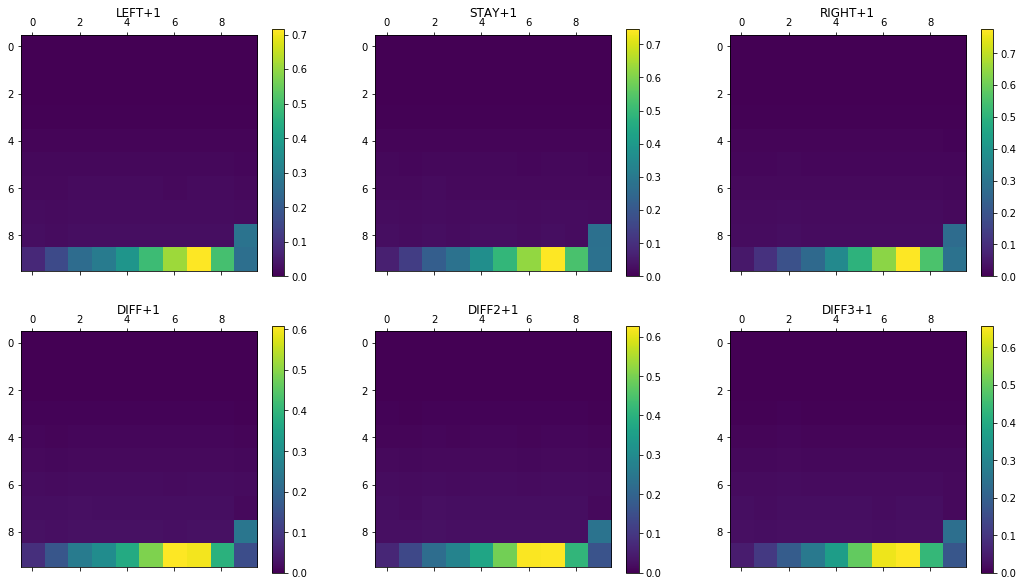

In [305]:
fig, ((ax1, ax2, ax3), (ax1d, ax2d, ax3d)) = plt.subplots(nrows=2, ncols=3, figsize=(18,10))

a = model.history[pfr_list.cpu().numpy().sum(0).argmax(), :-1]
a = a.view(5, 103)
a = a[0, :-3].clone()
a = a.view(-1)

sal = torch.cat((input_t, actions[0]), 0)
sar = torch.cat((input_t, actions[2]), 0)
san = torch.cat((input_t, actions[1]), 0)

# LEFTS 
sal_p = torch.cat((torch.zeros((sal.size(0)*2, 1)).type(FloatTensor), sal, torch.zeros((model._sith.T.size(0) - sal.size(0)*3, 1)).type(FloatTensor)), 0)
ssl = normalized.mm(sal_p)
t1 = ax1.matshow(ssl.view(10,10).numpy())
fig.colorbar(t1, ax=ax1)
ax1.set_title("LEFT+1")
sar_p = torch.cat((torch.zeros((sar.size(0)*2, 1)).type(FloatTensor), sar, torch.zeros((model._sith.T.size(0) - sar.size(0)*3, 1)).type(FloatTensor)), 0)
ssr = normalized.mm(sar_p)
t1 = ax3.matshow(ssr.view(10,10).numpy())
fig.colorbar(t1, ax=ax3)
ax3.set_title("RIGHT+1")
san_p = torch.cat((torch.zeros((san.size(0)*2, 1)).type(FloatTensor), san, torch.zeros((model._sith.T.size(0) - san.size(0)*3, 1)).type(FloatTensor)), 0)
ssn = normalized.mm(san_p)
t1 = ax2.matshow(ssn.view(10,10).numpy())
fig.colorbar(t1, ax=ax2)
ax2.set_title("STAY+1")
t1 = ax1d.matshow((ssl.view(-1)-a).view(10,10).numpy())
fig.colorbar(t1, ax=ax1d)
ax1d.set_title("DIFF+1")
t1 = ax2d.matshow((ssn.view(-1)-a).view(10,10).numpy())
fig.colorbar(t1, ax=ax2d)
ax2d.set_title("DIFF2+1")
t1 = ax3d.matshow((ssr.view(-1)-a).view(10,10).numpy())
fig.colorbar(t1, ax=ax3d)
ax3d.set_title("DIFF3+1")




In [164]:
t_save = model._sith._t.clone()

In [165]:
sa = torch.cat((input_tm1, model._actions[2]), 0)
model._sith.update_t(sa*model._dt, dur=model._dur)
model._sith.update_t(item=None, dur=model._delay)


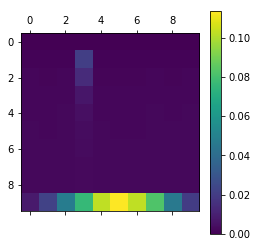

In [166]:
ssr = normalized.mm(model._sith.T.view(-1, 1)).view(10,10).cpu().numpy()
matshow(normalized.mm(model._sith.T.view(-1, 1)).view(10,10).cpu().numpy())
colorbar()

In [167]:
model._sith._t = t_save.clone()
model._sith._t_changed = True

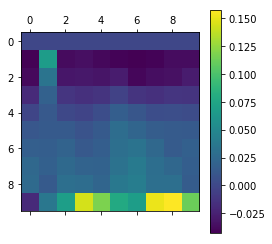

In [1774]:
matshow(model._M.mm(model._sith.T.view(-1, 1)).view(1, -1).view(10,10).cpu().numpy())
colorbar()

In [1770]:
left = model._M.mm(model._sith.T.view(-1, 1)).view(1, -1).view(10,10).cpu().numpy()


In [1775]:
right = model._M.mm(model._sith.T.view(-1, 1)).view(1, -1).view(10,10).cpu().numpy()

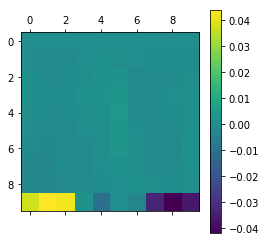

In [1778]:
matshow(left - right)
colorbar()

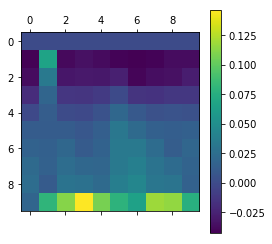

In [1779]:
matshow(left)
colorbar()

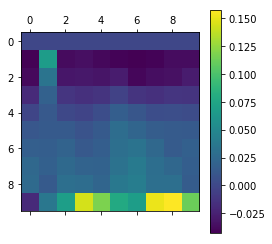

In [1780]:
matshow(right)
colorbar()

In [205]:
sith.update_t(item=sa1.view(-1), dur=1./30./10.)
sith.update_t(item=None, dur=(1./30.) - (1./30./10.))

In [206]:
reward, timestep, game_over = c.act(-1)

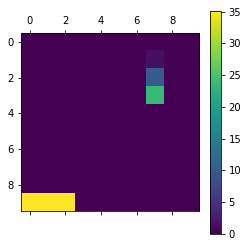

In [207]:
matshow(sith.T[0:100].view(10,10).cpu().numpy())
colorbar()

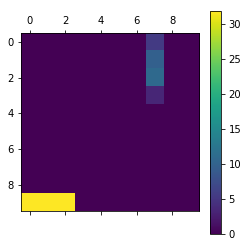

In [208]:
matshow(sith.T[103:203].view(10,10).cpu().numpy())
colorbar()

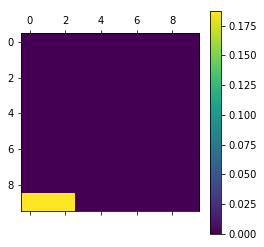

In [178]:
matshow(sith.T[206:306].view(10,10).cpu().numpy())
colorbar()

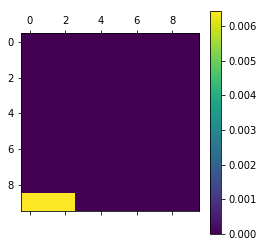

In [179]:
matshow(sith.T[309:409].view(10,10).cpu().numpy())
colorbar()

In [180]:
c.reset()

In [515]:
sith = SITH(103, dt=1./30./10., ntau=25, tau_0=1/30., dtype=np.float32, use_cuda=use_cuda)


515

In [40]:
testing = torch.eye(5).type(FloatTensor)

In [41]:
model = SithSR(state_len=5, action_len=1)

In [72]:
model.learn_step(testing[4], 0)

In [67]:
model._sith.T


 23.5166
  0.0091
  0.1207
  1.3464
 10.1742
 35.1670
  4.3522
  2.3697
  5.4488
  9.8690
 11.2486
 33.2884
  5.9313
  6.7224
  7.0543
  6.5078
  5.4633
 31.6792
  3.9863
  3.5588
  3.0496
  2.5119
  2.0013
 15.1064
  0.6671
  0.5180
  0.3874
  0.2776
  0.1892
  2.0391
[torch.FloatTensor of size 30]

In [521]:
model.history[:, :-1].clone().view(model.history.size(0), model._sith.tau_star[model._sith._T_full_ind].size-1, model._in_sith)

RuntimeError: invalid argument 2: input is not contiguous at /opt/conda/conda-bld/pytorch_1512387374934/work/torch/lib/THC/generic/THCTensor.c:227

In [535]:
model.history[:, :-1].clone().view(10, 5, 103)


( 0 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0784  0.0049  0.0339
  0.0000  0.0000  0.0000  ...   0.0205  0.0506  0.0398
  0.0000  0.0000  0.0000  ...   0.0383  0.0284  0.0310
  0.0000  0.0000  0.0000  ...   0.0180  0.0032  0.0128
  0.0000  0.0000  0.0000  ...   0.0020  0.0002  0.0013

( 1 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.1123  0.0004  0.0045
  0.0000  0.0000  0.0000  ...   0.0588  0.0191  0.0330
  0.0000  0.0000  0.0000  ...   0.0395  0.0296  0.0287
  0.0000  0.0000  0.0000  ...   0.0090  0.0086  0.0164
  0.0000  0.0000  0.0000  ...   0.0006  0.0007  0.0021

( 2 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0049  0.1123  0.0000
  0.0000  0.0000  0.0000  ...   0.0589  0.0480  0.0040
  0.0000  0.0000  0.0000  ...   0.0629  0.0058  0.0291
  0.0000  0.0000  0.0000  ...   0.0222  0.0003  0.0115
  0.0000  0.0000  0.0000  ...   0.0024  0.0000  0.0010
... 

( 7 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.1172  0.0000
  0.0000  0.0001  0.0000  ...   0.0031  0.1068  0.0010
  0.

In [540]:
sum(x for x in model.history[:, :-1].clone().view(-1) if x > 0)

18.165916631508708

In [552]:
a = model.history[:, :-1].clone()

In [557]:
a.gather(1, (a>0).type(LongTensor))



1.00000e-10 *
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
          ...             ⋱             ...          
 0.0000  5.8336  0.0000  ...   5.8336  5.8336  5.8336
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
[torch.cuda.FloatTensor of size 10x515 (GPU 0)]

In [562]:
ch = model.history[:, :-1].clone().view(model.history.size(0), 
                                                model._sith.tau_star[model._sith._T_full_ind].size-1, 
                                                model._in_sith).sum(1)[:, :-3]

In [593]:
Sp = model._M.mm(model._sith.T.view(-1, 1)).view(1, -1).expand_as(ch)

# subtract histories from Sp, creating a matrix of (histories, prediction errors)
pe = Sp - ch/5.

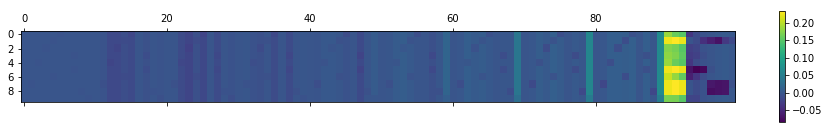

In [594]:
matshow(pe.cpu().numpy())
colorbar()

In [612]:
matshow(pe[(pe>0)].cpu().numpy())
colorbar()

ValueError: not enough values to unpack (expected 2, got 1)

In [650]:

1/(1+(p*(pe*(pe>0).type(FloatTensor)).sum(1) + (p - 1)*(pe*(pe<0).type(FloatTensor)).sum(1)))


 0.7419
 0.6623
 0.7501
 0.7345
 0.7529
 0.6498
 0.7215
 0.6504
 0.6480
 0.7674
[torch.cuda.FloatTensor of size 10 (GPU 0)]

In [652]:
p*(pe*(pe>0).type(FloatTensor)).sum(1) + (p - 1)*(pe*(pe<0).type(FloatTensor)).sum(1)


 0.3479
 0.5100
 0.3332
 0.3614
 0.3282
 0.5390
 0.3859
 0.5375
 0.5431
 0.3030
[torch.cuda.FloatTensor of size 10 (GPU 0)]